# Jonathan Halverson
# Tuesday, January 16, 2018
# TF word2vec code

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

### Step 1: Download the data and form a list of words

In [2]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
     """Create directories, ok if they already exist.
    
     This is for python 2 support. In python >=3.2, simply use:
     >>> os.makedirs(path, exist_ok=True)
     """
     try:
          os.makedirs(path)
     except OSError as exc:
          if exc.errno == errno.EEXIST and os.path.isdir(path):
               pass
          else:
               raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
     #os.makedirs(words_path, exist_ok=True)
     if not os.path.exists(WORDS_PATH):
          os.makedirs(words_path)
     zip_path = os.path.join(words_path, "words.zip")
     if not os.path.exists(zip_path):
          urllib.request.urlretrieve(words_url, zip_path)
     with zipfile.ZipFile(zip_path) as f:
          data = f.read(f.namelist()[0])
     return data.decode("ascii").split()

The code above downloads and creates a Python list of words. The words appear to all be in lower case and composed of only alphabetical characters (no punctuation, hypens, numbers, etc.).

In [3]:
words = fetch_words_data()

In [4]:
words[:10]

[u'anarchism',
 u'originated',
 u'as',
 u'a',
 u'term',
 u'of',
 u'abuse',
 u'first',
 u'used',
 u'against']

In [5]:
type(words)

list

In [6]:
len(words)

17005207

In [7]:
len(set(words))

253854

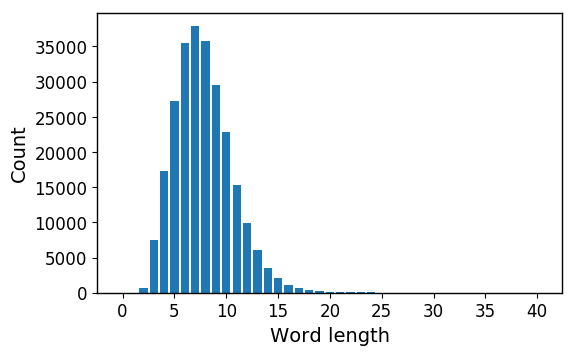

In [8]:
plt.hist([len(word) for word in set(words)], bins=np.linspace(-0.5, 40.5, 42), rwidth=0.8)
plt.xlabel('Word length')
plt.ylabel('Count')

Let's check for long words:

In [9]:
[word for word in set(words) if len(word) > 30]

[u'supercalifragilisticexpialidocious',
 u'dativecuicuicuiquibusquibusquibus',
 u'nthproofprovescomplexityformula',
 u'intelligenceespionagemanagement',
 u'autopistavespuciosurantesderuta',
 u'nnmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmn',
 u'sexmilliaquingentsexagintillion',
 u'dodecahedronicosidodecahedrontruncated',
 u'laurynhillthemiseducationoflaurynhillalbumcover',
 u'floccinaucinihilipilificastically',
 u'antidisestablishmentarianistically',
 u'hexdecimalglyphnamehexdecimalglyphname',
 u'llanfairpwllgwyngyllgogerychwyrn',
 u'generateprovablyparadoxicalstring',
 u'californiaofframpwrongwaysignage',
 u'dichlorodiphenyltrichloroethane',
 u'germanhungarianczechpolishruthenianromaniancroatslovakserbslovene',
 u'psychologyphilosophyneuroscience',
 u'execuwaefsfasdagadsfgadfgadfgtive',
 u'pseudoantidisestablishmentarianism',
 u'operationandcycleoffunctioningtf',
 u'pneumonoultramicroscopicsilicovolcanokoniosis',
 u'gammaracanthuskytodermogammarus',
 u'llanfairpwllgwyngyllgogerychwyrndrobwllllanty

### Step 2: Construct

In [10]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words]) # if word not found then UNK

In [11]:
vocabulary[:10]

array([u'UNK', u'the', u'of', u'and', u'one', u'in', u'a', u'to', u'zero',
       u'nine'], 
      dtype='<U28')

In [12]:
vocabulary[-10:]

array([u'amputee', u'chordal', u'cricketing', u'impressively', u'lith',
       u'cropped', u'mitsuda', u'bundesland', u'idm', u'thien'], 
      dtype='<U28')

In [13]:
dictionary.items()[:10]

[(u'fawn', 45848),
 (u'homomorphism', 9648),
 (u'nordisk', 39343),
 (u'nunnery', 36075),
 (u'chthonic', 33554),
 (u'sowell', 40562),
 (u'sonja', 38175),
 (u'showa', 32906),
 (u'woods', 6263),
 (u'hsv', 44222)]

In [14]:
data[:10]

array([5239, 3084,   12,    6,  195,    2, 3137,   46,   59,  156])

In [15]:
' '.join(words[:10])

u'anarchism originated as a term of abuse first used against'

In [16]:
dictionary['anarchism']

5239

The array called data gives the numerical code for each word in words. Words that did not fit into the vocabulary are given a code of 0 which corresponds to UNK. Here are the number of unknown words:

In [17]:
np.bincount(data)[0]

418391

In [18]:
data.tolist().count(0)

418391

What is the first unknown word?

In [19]:
idx = data.tolist().index(0)
words[idx]

u'culottes'

### Step 3: Generate batches

In [20]:
import random
from collections import deque

# num_skips is the number of times to reuse an input to generate a label
# skip_window is the number of words to consider left and right
def generate_batch(batch_size, num_skips, skip_window):
     global data_index
     assert batch_size % num_skips == 0
     assert num_skips <= 2 * skip_window
     batch = np.ndarray(shape=(batch_size), dtype=np.int32)
     labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
     span = 2 * skip_window + 1 # [ skip_window target skip_window ]
     buffer = deque(maxlen=span)
     for _ in range(span):
          buffer.append(data[data_index])
          data_index = (data_index + 1) % len(data)
     for i in range(batch_size // num_skips):
          target = skip_window  # target label at the center of the buffer
          targets_to_avoid = [ skip_window ]
          for j in range(num_skips):
               while target in targets_to_avoid:
                    target = random.randint(0, span - 1)
               targets_to_avoid.append(target)
               batch[i * num_skips + j] = buffer[skip_window]
               labels[i * num_skips + j, 0] = buffer[target]
          buffer.append(data[data_index])
          data_index = (data_index + 1) % len(data)
     return batch, labels

In [21]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [22]:
batch

array([3084, 3084,   12,   12,    6,    6,  195,  195], dtype=int32)

In [23]:
labels

array([[5239],
       [  12],
       [   6],
       [3084],
       [  12],
       [ 195],
       [   2],
       [   6]], dtype=int32)

In [24]:
[vocabulary[idx] for idx in batch]

[u'originated', u'originated', u'as', u'as', u'a', u'a', u'term', u'term']

In [25]:
[vocabulary[idx] for idx in labels.flatten()]

[u'anarchism', u'as', u'a', u'originated', u'as', u'term', u'of', u'a']

In [26]:
' '.join(words[:5])

u'anarchism originated as a term'

Above we see the meaning of the batch and labels entries. Let's look at another example where we take two words to either side:

In [27]:
data_index = 100
batch, labels = generate_batch(12, 4, 2)

In [28]:
[vocabulary[idx] for idx in batch]

[u'what',
 u'what',
 u'what',
 u'what',
 u'this',
 u'this',
 u'this',
 u'this',
 u'means',
 u'means',
 u'means',
 u'means']

In [29]:
[vocabulary[idx] for idx in labels.flatten()]

[u'of',
 u'means',
 u'this',
 u'interpretations',
 u'means',
 u'of',
 u'what',
 u'anarchism',
 u'anarchism',
 u'this',
 u'what',
 u'also']

In [30]:
' '.join(words[99:108])

u'differing interpretations of what this means anarchism also refers'

### Step 4: Build the model

In [31]:
tf.reset_default_graph()

In [32]:
batch_size = 128
num_skips = 2         # How many times to reuse an input to generate a label.
skip_window = 1       # How many words to consider left and right.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [33]:
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [34]:
embedding_size = 150
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [35]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [36]:
# Construct the variables for the NCE loss
dv = 1.0 / np.sqrt(embedding_size)
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=dv))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels,
                                     embed, num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer
init = tf.global_variables_initializer()

In [37]:
num_steps = 20001

with tf.Session() as session:
     init.run()

     average_loss = 0
     for step in range(num_steps):
          #print("\rIteration: {}".format(step))
          batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
          feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

          # We perform one update step by evaluating the training op (including it
          # in the list of returned values for session.run()
          _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
          average_loss += loss_val

          if step % 1000 == 0:
               if step > 0:
                    average_loss /= 2000
               # The average loss is an estimate of the loss over the last 2000 batches.
               print("Average loss at step ", step, ": ", average_loss)
               average_loss = 0

          # Note that this is expensive (~20% slowdown if computed every 500 steps)
          if step % 10000 == 0:
               sim = similarity.eval()
               for i in range(valid_size):
                    valid_word = vocabulary[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log_str = "Nearest to %s:" % valid_word
                    for k in range(top_k):
                         close_word = vocabulary[nearest[k]]
                         log_str = "%s %s," % (log_str, close_word)
                    print(log_str)

     final_embeddings = normalized_embeddings.eval()

('Average loss at step ', 0, ': ', 280.826416015625)
Nearest to state: cryptographers, jehoiachin, retrofitted, dodds, differed, brazzaville, scripts, nw,
Nearest to such: consenting, ag, agesilaus, onions, dependents, lithography, inverse, laughing,
Nearest to were: equilateral, protect, victor, diaconate, juliana, canola, palestinian, spreadsheets,
Nearest to UNK: booted, hairstyle, seaton, sustaining, scorpio, armored, uncompressed, pius,
Nearest to they: routines, forties, ministries, pwn, ooze, minded, ifbb, notion,
Nearest to one: buried, hammond, hooper, blanket, improves, sovereignty, policeman, exists,
Nearest to up: terse, neutronic, rask, frozen, hong, cpan, opencyc, tanach,
Nearest to which: guangzhou, diomedes, strolling, farmland, relays, intentions, destruct, scytale,
Nearest to has: weighed, alsos, kumamoto, sevens, simulator, guerra, july, agrarian,
Nearest to or: eccles, refrigerants, paragon, announces, proudest, jitter, bachchan, feuerbach,
Nearest to zero: pelican,

In [38]:
eb = final_embeddings
eb.shape

(50000, 150)

In [39]:
final_embeddings[1]

array([ 0.04362651, -0.01296019,  0.10988334,  0.04251041,  0.07170792,
       -0.08827364, -0.13532993, -0.01901955,  0.06818365,  0.05668408,
        0.0579356 , -0.01003622,  0.09277426, -0.11824943, -0.09043928,
        0.07213573,  0.02817677, -0.06768905,  0.06177396,  0.04714949,
       -0.11052685,  0.04519225,  0.00632382, -0.07515419,  0.10710907,
        0.02233827, -0.05641621, -0.04626361,  0.1101991 ,  0.04609577,
        0.0678784 ,  0.06673404,  0.05313535, -0.09922433, -0.13039616,
        0.11468837,  0.08909929,  0.01969854,  0.08919692,  0.12712643,
       -0.05152662,  0.08879393,  0.08562955, -0.07407413,  0.03741914,
        0.0012532 ,  0.06425124, -0.07815652,  0.03498382, -0.05433923,
        0.02153288, -0.11108754,  0.0909961 , -0.08306859, -0.03756995,
        0.10345288,  0.12437445, -0.11413002, -0.13026661,  0.02090331,
       -0.01500239, -0.11902469,  0.145302  ,  0.05053392,  0.16835131,
        0.08974805, -0.10546048, -0.0153188 , -0.01479571,  0.08

In [40]:
from scipy.spatial import distance

In [41]:
def closests_words(word):
     if (word not in vocabulary):
          return -1
     word1_idx = dictionary[word]
     eb1 = final_embeddings[word1_idx]
     distance_word = [(distance.cosine(eb1, final_embeddings[i]), vocabulary[i])
                      for i in xrange(vocabulary_size)]
     return sorted(distance_word)[1:31]

In [42]:
def distances(word1, word2):
     if (word1 not in vocabulary or word2 not in vocabulary):
          return -1
     word1_idx = dictionary[word1]
     word2_idx = dictionary[word2]
     eb1 = final_embeddings[word1_idx]
     eb2 = final_embeddings[word2_idx]
     return '%.2f/%.2f' % (distance.euclidean(eb1, eb2), distance.cosine(eb1, eb2))

In [43]:
closests_words('car')

[(0.55539971590042114, u'fastest'),
 (0.5689464807510376, u'driver'),
 (0.57045713067054749, u'cruises'),
 (0.58465418219566345, u'dominion'),
 (0.592934250831604, u'montmartre'),
 (0.59419453144073486, u'freeze'),
 (0.59794920682907104, u'azov'),
 (0.59877419471740723, u'signatory'),
 (0.6042182445526123, u'deviated'),
 (0.60964632034301758, u'bowel'),
 (0.61126676201820374, u'preposition'),
 (0.61689025163650513, u'kibbutz'),
 (0.61901500821113586, u'flakes'),
 (0.62169873714447021, u'vous'),
 (0.62228751182556152, u'drucker'),
 (0.62389329075813293, u'field'),
 (0.62408819794654846, u'larsen'),
 (0.62504592537879944, u'khad'),
 (0.6269058883190155, u'jackie'),
 (0.62793150544166565, u'typology'),
 (0.62853091955184937, u'whichever'),
 (0.63011029362678528, u'bulwark'),
 (0.63076218962669373, u'medieval'),
 (0.63122543692588806, u'eugenic'),
 (0.6316506564617157, u'marmalade'),
 (0.63196763396263123, u'pim'),
 (0.63244947791099548, u'lenny'),
 (0.6332593560218811, u'insult'),
 (0.633

In [44]:
print distances('dog', 'cat')

1.16/0.67


In [45]:
print distances('dog', 'wagon')

1.24/0.77


In [46]:
print distances('radio', 'rum')

1.35/0.92


In [47]:
print distances('rattle', 'yacht')

1.46/1.06


In [48]:
print distances('hippie', 'cambridge')

1.45/1.05


In [49]:
print distances('book', 'page')

1.14/0.65


In [50]:
print distances('man', 'king')

1.10/0.60


In [51]:
print distances('sport', 'activity')

1.15/0.67


In [52]:
print distances('the', 'with')

0.94/0.45


In [53]:
print distances('winter', 'summer')

1.06/0.56


In [54]:
print distances('truck', 'car')

1.26/0.79


One must keep in mind that some words only appear infrequently in the corpus so their embeddings are noisy.

Below we estimate the mean values of the two distances over all the embeddings:

In [55]:
pairs = [np.random.choice(vocabulary_size, 2, replace=False) for _ in xrange(10000)]
print np.array([distance.euclidean(eb[pair[0]], eb[pair[1]]) for pair in pairs]).mean()
print np.array([distance.cosine(eb[pair[0]], eb[pair[1]]) for pair in pairs]).mean()

1.32365610876
0.88228483334


### Step 5: Plot the embeddings

In [56]:
def plot_with_labels(low_dim_embs, labels):
     assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
     plt.figure(figsize=(18, 18))  #in inches
     for i, label in enumerate(labels):
          x, y = low_dim_embs[i,:]
          plt.scatter(x, y)
          plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

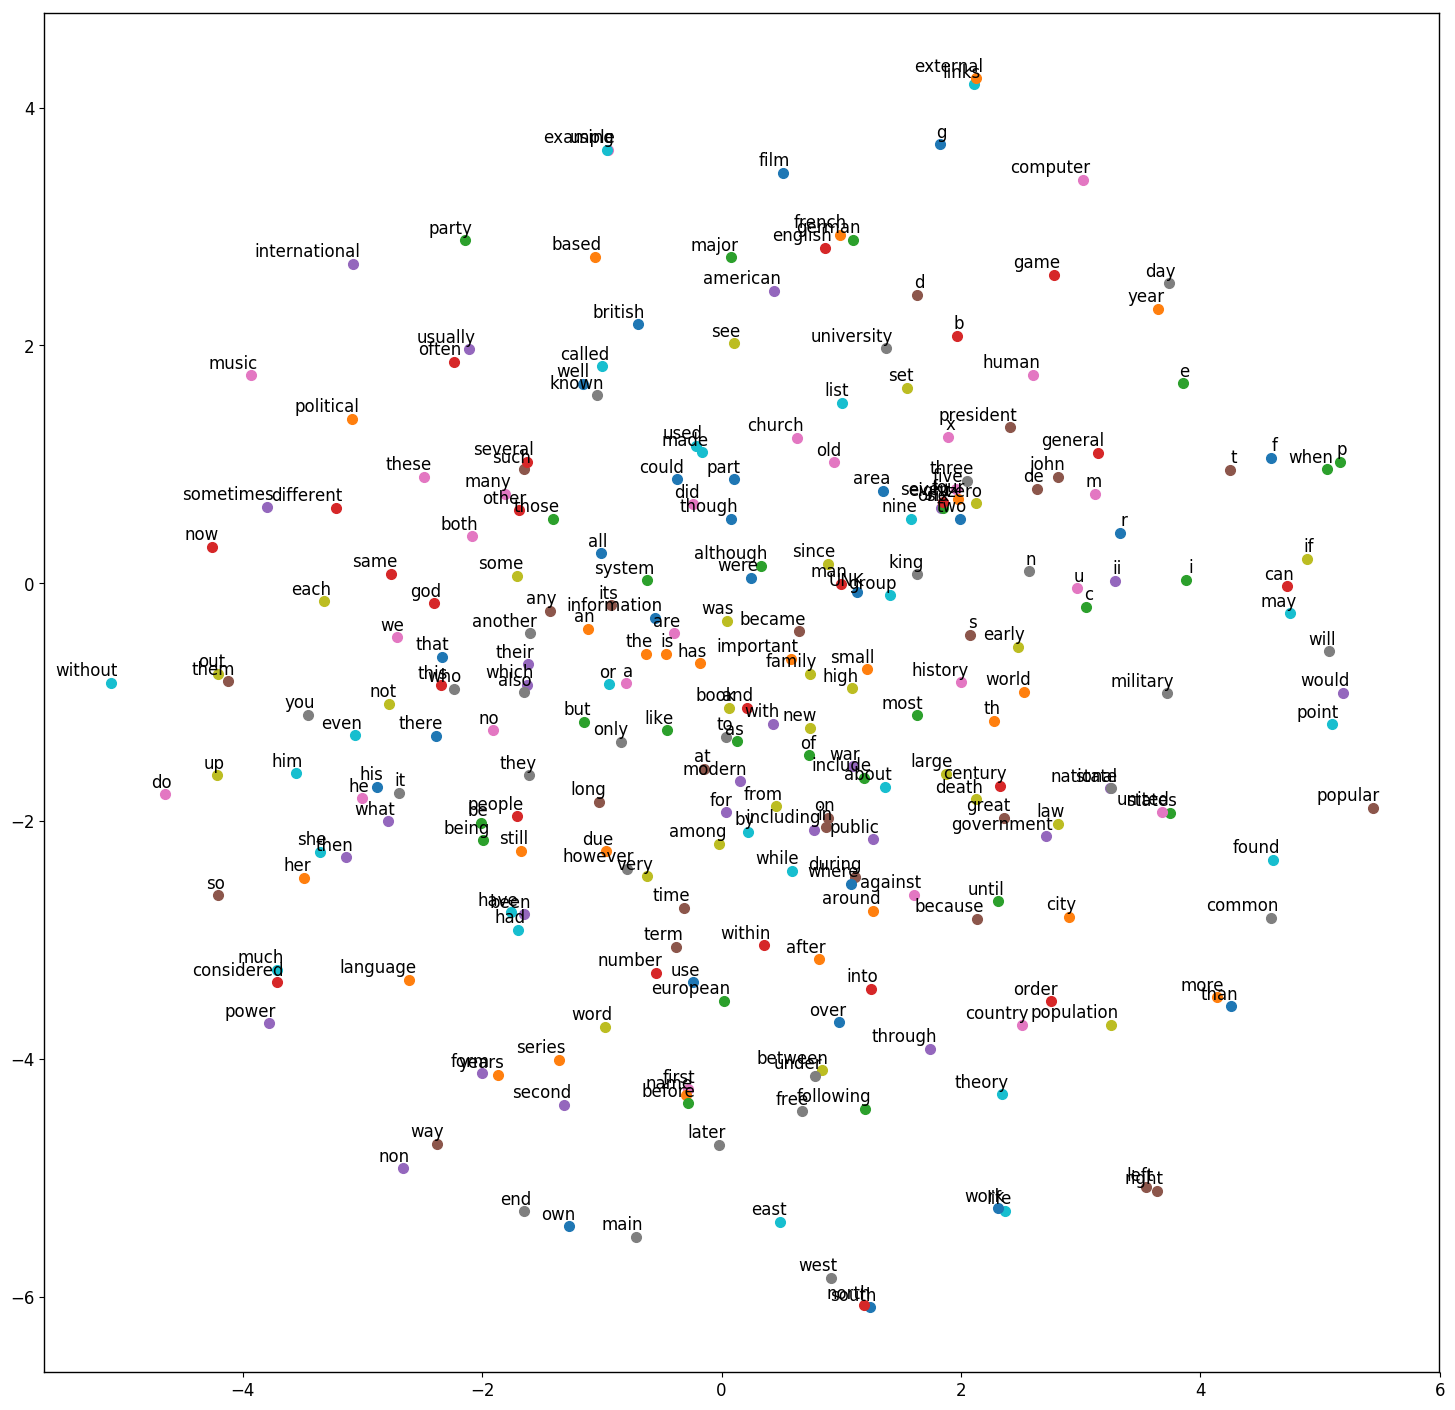

In [57]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 250
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)